In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_3707/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

(array([0., 1.]), array([35052, 34948]))


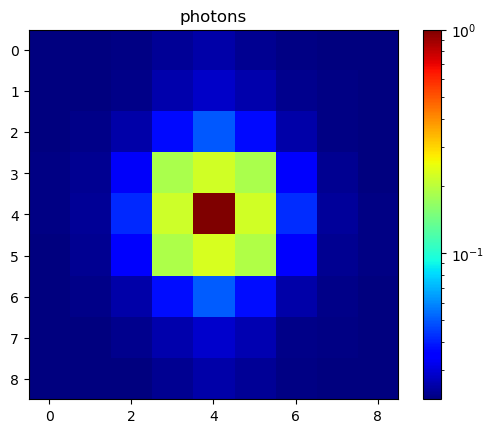

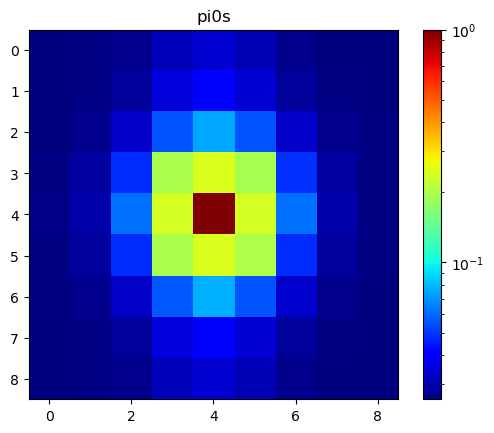

In [5]:
### visualise the dataset
dataset = np.loadtxt("output0.csv")
print(np.unique(dataset[:,81],return_counts=True))
pis = dataset[:,:81][dataset[:,81] == 0]
phos = dataset[:,:81][dataset[:,81] == 1]
from matplotlib import colors
im1 = plt.imshow(np.mean(phos.reshape(len(phos),9,9),axis=0),cmap='jet',norm=colors.LogNorm())
plt.colorbar(im1)
plt.title("photons")
plt.show()
im2 = plt.imshow(np.mean(pis.reshape(len(pis),9,9),axis=0),cmap='jet',norm=colors.LogNorm())
plt.colorbar(im2)
plt.title("pi0s")
plt.show()

In [41]:
## define dataset

from torch.utils.data import Dataset
class ClassificationDataset_PC(Dataset):
    def __init__(self, filename):
        self.filename_ = filename
        self.data = np.loadtxt(self.filename_)
        self.imageflat = torch.tensor(self.data[:,:81],dtype=torch.float)
        self.images = torch.reshape(self.imageflat, (len(self.imageflat),9, 9))
        self.labels = torch.tensor(self.data[:,81],dtype=torch.double)
        self.pc_dataset = [ self.transform_2d_img_to_point_cloud(self.images[idx],self.labels[idx]) for idx in range(len(self.imageflat)) ]
        self.pc = torch.stack([i['point'] for i in self.pc_dataset],dim=0)
    
    def transform_2d_img_to_point_cloud(self, image, label) :
    
        img, label = image, label
        #img_array = img[0]
        values = img.flatten()
        x_coord = torch.argwhere(img > -1.)[:,0]/img.shape[0]
        y_coord = torch.argwhere(img > -1.)[:,1]/img.shape[0]
        
        point_vec = torch.stack( (x_coord, y_coord, values), dim=-1)
        
        return {'point' : point_vec, 'label' : label, 'seq_length' : len(point_vec)}

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        
        
        return self.pc[idx], self.labels[idx]
    


In [42]:
### create dataset, dataloaders
train_datasetDS = ClassificationDataset_PC("output0.csv")
test_datasetDS = ClassificationDataset_PC("output1.csv")


In [77]:
ntrainbatch = 20
ntestbatch = 20
from torch.utils.data import DataLoader
trainloaderDS = DataLoader(train_datasetDS, batch_size=ntrainbatch)
testloaderDS = DataLoader(test_datasetDS, batch_size=ntestbatch)

In [32]:
### define Deepsets model
## model from here: https://github.com/sanmayphy/ICTS_ML_SCHOOL/blob/main/Day1/DeepSets_Tutorial.ipynb
class DeepSetLayer(nn.Module):
    def __init__(self, in_features:int, out_features:int,  normalization:str = '', pool:str = 'mean') -> None :
        """
        DeepSets single layer
        :param in_features: input's number of features
        :param out_features: output's number of features
        :param attention: Whether to use attention
        :param normalization: normalization method - 'fro' or 'batchnorm'
        
        """
        super(DeepSetLayer, self).__init__()

        self.Gamma = nn.Linear(in_features, out_features)
        self.Lambda = nn.Linear(in_features, out_features)

        self.normalization = normalization
        self.pool = pool
        
        if normalization == 'batchnorm':
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x : torch.Tensor) -> torch.Tensor :
        # x.shape = (B, N, C)
        if(self.pool == 'mean') : 
            x = self.Gamma(x) + self.Lambda(x - x.mean(dim=1, keepdim=True)) # -- the average is over the points -- #
        elif(self.pool == 'max') :
            x = self.Gamma(x) + self.Lambda(x - x.max(dim=1, keepdim=True)) # -- the max is over the points -- #

        # normalization
        if self.normalization == 'batchnorm':
            x = self.bn(x)
        

        return x


class DeepSet(nn.Module):
    def __init__(self, in_features:int, feats:list, n_class:int, normalization:str = '', pool:str = 'mean') ->None:
        """
        DeepSets implementation
        :param in_features: input's number of features
        :param feats: list of features for each deepsets layer
        """
        super(DeepSet, self).__init__()

        layers = []

        layers.append(DeepSetLayer(in_features = in_features, out_features = feats[0], normalization = normalization, pool = pool))
        for i in range(1, len(feats)):
            layers.append(nn.ReLU())
            layers.append(DeepSetLayer(in_features = feats[i-1], out_features = feats[i], normalization = normalization, pool = pool))

        layers.append(DeepSetLayer(in_features = feats[-1], out_features = n_class, normalization = normalization, pool = pool))
        #self.sequential = nn.Sequential(*layers)
        self.sequential = nn.ModuleList(layers)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        #return self.sequential(x)
        for i, layer in enumerate(self.sequential):
            x = layer(x)
        
        x = x.mean(dim=1) # -- average over the points -- #
        out = F.log_softmax(x, dim=-1)
        
        return out
    
    
#netcnn = NetCNN()

In [43]:
pc_chunk, label_chunk = next(iter(trainloaderDS))
print(pc_chunk.shape, label_chunk.shape)
ds_layer = DeepSetLayer(in_features = 3, out_features = 4)
y = ds_layer(pc_chunk)
pc_chunk.shape, y.shape

torch.Size([2000, 81, 3]) torch.Size([2000])


(torch.Size([2000, 81, 3]), torch.Size([2000, 81, 4]))

In [75]:
### define training and testing functions

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)

model = DeepSet(in_features=3, feats=[5, 9, 12, 16, 13], n_class=2)
model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
lossfunction = nn.BCELoss()


def train(epoch):
    model.train()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(trainloaderDS):  ### change to loaderDNN for DNN
            image, label = data[0].to(device),data[1].to(device)
            label = label.to(torch.long)
            optimizer.zero_grad()
            result = model(image)
            #print(label.dtype)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            pred_labels = torch.argmax(result, dim=-1) 
            true_preds += (pred_labels == label).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloaderDS): ### change to loaderDNN for DNN
            image, label = data[0].to(device),data[1].to(device)
            label = label.to(torch.long)
            optimizer.zero_grad()
            result = model(image)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result, dim=-1) 
            true_preds += (pred_labels == label).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

In [ ]:
### loop over the datset and train/test

from tqdm import tqdm as tqdm
nepoch=20
best_loss = 99999999
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    trainl = train(epoch)
    losst.append(trainl[0])
    acct.append(trainl[1])
    testl = test(epoch)
    loss_epoch = testl[0]
    lossv.append(loss_epoch)
    accv.append(testl[1])
    epochs.append(epoch)

    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        
    if ((epoch+1)%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.legend()
        plt.title("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        plt.plot(np.array(epochs),np.array(acct),c='b',label='training')
        plt.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        plt.legend()
        plt.title("accuracy")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
    #break

In [62]:
for data in tqdm(trainloaderDS):  ### change to loaderDNN for DNN
            image, label = data[0].to(device),data[1].to(device)
            print(image[0].shape)
            break

  0%|          | 0/35 [00:00<?, ?it/s]

torch.Size([81, 3])


In [68]:
def visualize_samples(data, label, marker='o'):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
        
    plt.figure(figsize=(4,4))
    plt.scatter(data[:,0] , data[:,1], edgecolor="#333",s =data[:,2]*100 , marker=marker, label="Class " + str(label))
    
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

  0%|          | 0/35 [00:00<?, ?it/s]


torch.Size([2000, 81, 3])


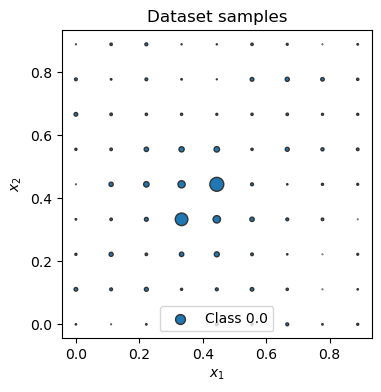

In [74]:
for data in tqdm(trainloaderDS):  ### change to loaderDNN for DNN
            image, label = data[0].to(device),data[1].to(device)
            visualize_samples(image[0],label[0])
            
            print(data[0].shape,)
            break